In [1]:
#Creating CNN from scratch
#Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [59]:
class ConvNet(object):
    
    def __init__(self):
        #defining hyperparams
        self.learning_rate = 0.001
        self.reg = 0.0001
        self.epochs = 21
        self.batch_size = 30
        
    #LOSS FUNCTION
    #Softmax log loss
    def softmax_loss(self, scores, y):
        #This line is used just in case of one hot encoding
        logs = -np.log(scores[range(scores.shape[0]), np.argmax(y, axis=1)])
        data_loss = np.sum(logs)/scores.shape[0]
        reg_loss = 0.5 * self.reg * np.sum(self.W1**2) + 0.5 * self.reg * np.sum(self.W2**2) +  0.5 * self.reg * np.sum(self.W3**2) +  0.5 * self.reg * np.sum(self.W4**2) 
        loss = data_loss + reg_loss
        return loss
    
    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
    
    
    ################################
    # DEFINING LAYERS FOR ConvNet  #
    ################################
    
    def conv2d(self, x, w, b, stride=1, padding=0):
        
        #Getting sizes
        N, D, H, W = x.shape
        F, D, Hf, Wf = w.shape
        
        #Getting size for the output from this layer
        Hout = int(1 + (H - Hf + 2*padding)/stride)
        Wout = int(1 + (W - Wf + 2*padding)/stride)
        
        padded_x = np.pad(x, [(0, 0), (0, 0), (padding, padding), (padding, padding)], 'constant')
        
        out = np.zeros((N, F, Hout, Wout))
        
        #getting for each image
        for i in range(N):
            #for each kenrnel
            for j in range(F):
                #convolving
                for o in range(Hout):
                    hPart = o*stride
                    for k in range(Wout):
                        wPart = k*stride
                        
                        convPart = padded_x[i, :, hPart:hPart+Hf, wPart:wPart+Wf]
                        out[i, j, o, k] = np.sum((convPart * w[j]))  + b[j]
                        
        cache = (x, w, b, stride, padding)
        return out, cache
    
    def conv2d_backprop(self, deriv_prev, cache):
        
#         deriv_prev = deriv_prev.reshape(deriv_prev.shape[1], deriv_prev.shape[2], deriv_prev.shape[3], deriv_prev.shape[4])
        x, w, b, stride, padding = cache
        
        N, D, H, W = x.shape
        F, D, Hf, Wf = w.shape
        
        Hout = int(1 + (H - Hf + 2*padding)/stride)
        Wout = int(1 + (W - Wf + 2*padding)/stride)
        
        dx = np.zeros_like(x)
        dW = np.zeros_like(w)
        db = np.zeros_like(b)
        
        padded_x = np.pad(x, [(0, 0), (0, 0), (padding, padding), (padding, padding)], 'constant')

        padded_dx = np.pad(dx, [(0, 0), (0, 0), (padding, padding), (padding, padding)], 'constant')
        
        
        for i in range(N):
            for j in range(F):
                
                #We need to derive with same parts as we need forward prop
                for o in range(Hout):
                    hPart = o * stride
                    for k in range(Wout):
                        wPart = k*stride
                        
                        convPart = padded_x[i, :, hPart:hPart+Hf, wPart:wPart+Wf]
                        #calculating derivatives
                        
                        db[j] += np.sum(deriv_prev[i, j, o, k], axis=0, keepdims=True)
                        dW[j] += convPart * deriv_prev[i, j, o, k]
                        padded_dx[i, :, hPart:hPart+Hf, wPart:wPart+Wf] += np.dot(w[j], deriv_prev[i, j, k, o])
         
        #move zeros from sides
        dx = padded_dx[:, :, padding:padding+H, padding:padding+W]
        return dx, dW, db
    
    #by default max_pool2d will slice input by half
    def max_pool2d(self, x, fil_size=[2, 2], stride=2):
        #Shape of the data
        N, D, H, W = x.shape
        
        
        Hout = int(1 + (H - fil_size[0])/stride)
        Wout = int(1 + (W - fil_size[1])/stride)

        out = np.zeros((N, D, Hout, Wout))
        
        for i in range(N):
            for j in range(D):
                
                for o in range(Hout):
                    hPart = o * stride
                    for k in range(Wout):
                        wPart = k * stride
                        
                        maxPart = x[i, j, hPart:hPart+fil_size[0], wPart:wPart+fil_size[1]]
                        
                        out[i, j, o, k] = np.max(maxPart)
        
        cache = (x, fil_size, stride)  
        
        return out, cache
        
    
    def max_pool2d_backprop(self, deriv_prev, cache):
        
        x, fil_size, stride = cache
        
        N, D, H, W = x.shape
        
        
        Hout = int(1 + (H - fil_size[0])/stride)
        Wout = int(1 + (W - fil_size[1])/stride)
           
        dx = np.zeros_like(x)
        
        for i in range(N):
            for j in range(D):
                
                for o in range(Hout):
                    hPart = o * stride
                    for k in range(Wout):
                        wPart = k * stride
                        
                        maxPart = x[i, j, hPart:hPart+fil_size[0], wPart:wPart+fil_size[1]]
                        
                        maxOfPart = np.max(maxPart)
                        
                        dx[i, j, hPart:hPart+fil_size[0], wPart:wPart+fil_size[1]] += (maxPart == maxOfPart) * deriv_prev[i, j, o, k]
                           
        return dx
    
    def relu_layer(self, x):
        out = np.maximum(x, 0)
        cache = x
        return out, cache        
    
    def relu_layer_backprop(self, deriv_prev, cache):
        x = cache
        dx = deriv_prev * (x > 0)
        return dx
    
    def fully_connected(self, x, w, b, last_layer=False):
        out = x.reshape(x.shape[0], np.prod(x.shape[1:])).dot(w)+b
        cache = (x, w, b)
        return out, cache
    
    def fully_connected_backprop(self, deriv_prev, cache):
        x, w, b = cache
        dw = x.reshape(x.shape[0], np.prod(x.shape[1:])).T.dot(deriv_prev)
        db = np.sum(deriv_prev, axis=0, keepdims=True)
        dx = deriv_prev.dot(w.T).reshape(x.shape) 
        return dx, dw, db
    
    ############################################
    
    def train(self, X_train, y_train):
        loss_history = []
        
        #defining weights and baiases
        self.W1 = np.random.randn(32, 1, 3, 3) / np.sqrt(32)
        self.b1 = np.zeros((32, 1)) / np.sqrt(32)
        self.W2 = np.random.randn(64, 32, 3, 3) / np.sqrt(64)
        self.b2 = np.zeros((64, 1)) / np.sqrt(64)
        self.W3 = np.random.randn(7 * 7 * 64, 1024) / np.sqrt(7 * 7 * 64)
        self.b3 = np.zeros((1, 1024)) / np.sqrt(1024)
        self.W4 = np.random.randn(1024, 10) / np.sqrt(1024)
        self.b4 = np.zeros((1, 10)) / np.sqrt(10)
        
        
        #Training loop
        for i in range(self.epochs):
            #getting scores for forward prop
            inx = np.random.choice(X_train.shape[0], self.batch_size, replace=True)
            X_batch = X_train[inx,:,:,:]
            y_batch = y_train[inx,:]
            
            cache, l1, l2, l3, scores = self.forward_prop(X_batch)
            
            #unppacing cache
            cacheConv1, cachel1, cacheMax1, cacheConv2, cachel2, cacheMax2, cacheFc1, cachel3, cacheFc2 = cache
            
            loss = self.softmax_loss(scores, y_batch)
            loss_history.append(loss)
            if i % 5 == 0:
                print("Epcohe: ", i, " of ", self.epochs, " Loss: ", loss)
             
            #Getting derivation from last layer
            dscores = scores
            dscores[range(X_batch.shape[0]), np.argmax(y_batch, axis=1)] -= 1
            
            #Backprop
            ddl4, dW4, db4 = self.fully_connected_backprop(dscores, cacheFc2)
            dl3 = self.relu_layer_backprop(ddl4, cachel3)
            ddl3, dW3, db3 = self.fully_connected_backprop(dl3, cacheFc1)
            dMl2 = self.max_pool2d_backprop(ddl3, cacheMax2)
            dl2 = self.relu_layer_backprop(dMl2, cachel2)
            ddl2, dW2, db2 = self.conv2d_backprop(dl2, cacheConv2)
            dMl1 = self.max_pool2d_backprop(ddl2, cacheMax1)
            dl1 = self.relu_layer_backprop(dMl1, cachel1)
            dx, dW1, db1 = self.conv2d_backprop(dl1, cacheConv1)
            
            #Regularization
            dW4 += self.reg * self.W4
            dW3 += self.reg * self.W3
            dW2 += self.reg * self.W2
            dW1 += self.reg * self.W1
            
            #SGD
            self.W4 += -self.learning_rate * dW4
            self.b4 += -self.learning_rate * db4
            self.W3 += -self.learning_rate * dW3    
            self.b3 += -self.learning_rate * db3
            self.W2 += -self.learning_rate * dW2
            self.b2 += -self.learning_rate * db2
            self.W1 += -self.learning_rate * dW1
            self.b1 += -self.learning_rate * db1
            
                  
        return loss_history
   
    #ADD CACHE return
    def forward_prop(self, X):
        
        #First Conv layer
        l1, cacheConv1 = self.conv2d(X, self.W1, self.b1, padding=1)        
        l1, cachel1 = self.relu_layer(l1)      
        l1, cacheMax1 = self.max_pool2d(l1)
        
        #Second Conv layer
        l2, cacheConv2 = self.conv2d(l1, self.W2, self.b2, padding=1)
        l2, cachel2 = self.relu_layer(l2)
        l2, cacheMax2 = self.max_pool2d(l2)
        
        #First fully connected layer
        l3, cacheFc1 = self.fully_connected(l2, self.W3, self.b3)
        l3, cachel3 = self.relu_layer(l3)
        
        #Output layer
        scores, cacheFc2 = self.fully_connected(l3, self.W4, self.b4, last_layer=True)
        scores = self.softmax(scores)
        
        cache = (cacheConv1, cachel1, cacheMax1, cacheConv2, cachel2, cacheMax2, cacheFc1, cachel3, cacheFc2)
        return cache, l1, l2, l3, scores
        
    
    def predict(self, X):
        _, _, _, _, scores = self.forward_prop(X)
        
        pred = np.argmax(scores, axis=1)
        return pred 

In [3]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [4]:
def accuracy(y_test, y_pred):
    correct = 0
    for i in range(len(y_pred)):
        helper_int = 0
            
        if y_pred[i] == y_test[i]:
            correct += 1
            
    return correct/len(y_pred) * 100

In [5]:
#Res#haping train and test set

#Just for MNIST
x_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
print(X_train.shape, " -> ", x_train.shape)
print(y_train.shape)
x_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
print(X_test.shape, " -> ", x_test.shape)
print(y_test.shape)

(55000, 784)  ->  (55000, 1, 28, 28)
(55000, 10)
(10000, 784)  ->  (10000, 1, 28, 28)
(10000, 10)


In [60]:
cnn = ConvNet()
loss = cnn.train(x_train, y_train)

Epcohe:  0  of  21  Loss:  2.37773051597
Epcohe:  5  of  21  Loss:  2.22106270489
Epcohe:  10  of  21  Loss:  2.0836345977
Epcohe:  15  of  21  Loss:  1.8782287578
Epcohe:  20  of  21  Loss:  1.90596345138


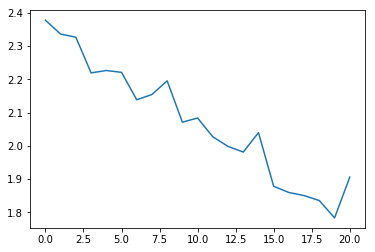

In [61]:
plt.plot(loss)
plt.show()

In [68]:
inx = np.random.choice(x_test.shape[0], 55, replace=True)
test_batch_x = x_test[inx,:, :, :]
test_batch_y = y_test[inx, :]
pred = cnn.predict(test_batch_x)
print(accuracy(pred, np.argmax(test_batch_y, axis=0)))

20.0
